# **Convolutional Neural Network Filter Bank for Musical Instruments Classification**

# Professor Supervisor: Prof. Gerald Schuller
# Research Assistant Supervisor: Renato de C. R. Profeta
# Author: Param Tushar Gadam
# Date: 1st June, 2020
# Master of Science in Communications and Signal Processing, Ilmenau University of Technology, Germany

# **Colab Runtime Configurations**

In [1]:
# Install torchaudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.9MB 8.2MB/s 


# **Imports and Configuration**

In [2]:
# Imports

## Numerical Computing
import numpy as np
import itertools

## File System and Files Handling
import os
from zipfile import ZipFile

## Python Serialization
import pickle

## Audio Processing
import librosa.display, librosa
import torchaudio

## Plotting and Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.core.display import HTML, display, Image

## Machine Learning ´
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import mean_squared_error

## Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import math

In [3]:
# Seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [4]:
## Check CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#map_location=torch.device('cpu')
#please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
#torch.load(map_location)

cuda


In [5]:
# Configure Tensorboard
%load_ext tensorboard

In [6]:
#logs_base_dir = "runs"
#os.makedirs(logs_base_dir, exist_ok=True)

# **Download the dataset from Dropbox**

In [7]:
# Download the dataset from Dropbox
!wget -O dataset.zip https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0

--2021-06-01 20:50:38--  https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip [following]
--2021-06-01 20:50:38--  https://www.dropbox.com/s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce51bb42ce41b163de3d6e961c2.dl.dropboxusercontent.com/cd/0/inline/BPl3eWcLVs5EZWcCpJH2cdqUJrswX9UH99VHrJUrOIh7ZycLDxsGYZ0dHpduCMcTZEfHnSUpOsplfMA6dfGC5i13mky4qQ40f31q2RKdW_FSUyzNnfJpFs4zpgmIBWTg1PJZi-x8i-vJf9QqTaHwmK5e/file# [following]
--2021-06-01 20:50:39--  https://uce51bb42ce41b163de3d6e961c2.dl.dropboxusercontent.com/cd/0/inline/BPl3eWcLVs5EZWcCpJH2cdqUJrswX9UH99VHrJUrOIh7ZycLDxs

# **Extract .zip**

In [8]:
with ZipFile('dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

# **Get Dataset Metadata from GitHub**

In [9]:
# Clone github in Google Colab
!git clone https://github.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-.git

Cloning into '-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-'...
remote: Enumerating objects: 2538, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 2538 (delta 28), reused 29 (delta 12), pack-reused 2483
Receiving objects: 100% (2538/2538), 2.08 GiB | 37.64 MiB/s, done.
Resolving deltas: 100% (1494/1494), done.
Checking out files: 100% (413/413), done.


In [10]:
# Load Train Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/train_set_dataframe.pkl', 'rb') as f:
  train_set = pickle.load(f)
#Load Test Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/test_set_dataframe.pkl', 'rb') as f:
  test_set = pickle.load(f)

# **Encode Labels**

In [11]:
# Encode Labels Test Set
labelencoder = LabelEncoder()
labelencoder.fit(test_set['class'].values.tolist())
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_int_test = labelencoder.transform(test_set['class'].values.tolist())

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels_test=encoder.fit_transform(classes_int_test.reshape(len(classes_int_test),1))

20 classes: banjo, bass-clarinet, bassoon, cello, clarinet, contrabassoon, double-bass, english-horn, flute, french-horn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin


# **Create PyTorch Datasets for Training and Testing**

In [20]:
# Dataset Class
class dataset(Dataset):
    """An abstract class representing a Dataset.

    Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau Germany
    """
    def __init__(self, files, labels):
        self.labels = labels
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
      x_numpy = np.load(self.files[index])
      X = torch.from_numpy(x_numpy)
      X /= torch.abs(X).max()  # Normalize
      X = torch.reshape(X,(1,-1)) # Reshape for Model
      y_labels = torch.tensor(self.labels[index]) #Labels Out
      return X,y_labels

In [21]:
# Create Sets
#train_set_torch = dataset(train_set['filename'].values.tolist(), onehot_labels_train)
test_set_torch = dataset(test_set['filename'].values.tolist(), onehot_labels_test)

In [22]:
# Data Loader.
#training_generator = DataLoader(train_set_torch, batch_size=1, shuffle=False, num_workers=0)
validation_generator = DataLoader(test_set_torch, batch_size=1, shuffle=False, num_workers=0)

# **Testing Dataset and Dataloader**

In [23]:
# Get a random audio file and label from dataset
dataiter = iter(DataLoader(test_set_torch, batch_size=1, shuffle=True, num_workers=0))
audio_to_test, label_to_test = dataiter.next()

In [24]:
# Calculate Spectrogram of the audio file to test
specgram = torchaudio.transforms.Spectrogram(n_fft=2048)(audio_to_test[0,0,:])

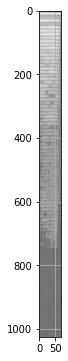

In [25]:
# Plot Spectrogram of audio to test
plt.figure(figsize=(10,6))
plt.imshow(20*specgram.log10().numpy(), cmap='gray')
plt.grid()

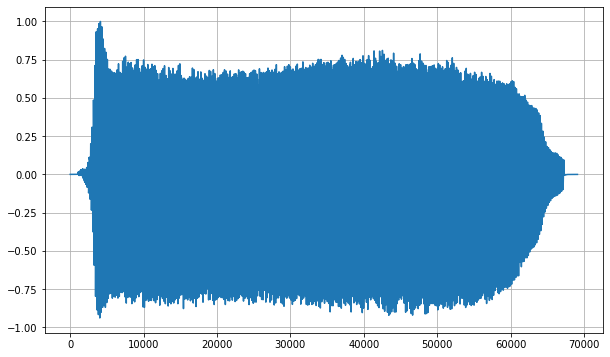

In [26]:
# Plot Waveform of audio to test
plt.figure(figsize=(10,6))
plt.plot(audio_to_test[0,0,:])
plt.grid()

In [27]:
# Listen to audio
ipd.Audio(audio_to_test[0,0,:], rate=44100) # load a local WAV file

# **Experiment Results for experiment 2**

#  load pickle file needed for plotting results for experiment 2

In [68]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/histexp2.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [69]:
hist = hist1['hist']
print(hist)

{'valid_loss': [0.6558845449564732], 'valid_loss_decoder': [0.00012231606008827382], 'valid_loss_total': [0.6681161510003595], 'valid_accuracies': [0.7790284128043848], 'valid_predictions': [[18, 8, 6, 3, 19, 2, 4, 19, 4, 12, 17, 2, 9, 15, 6, 17, 8, 18, 5, 6, 14, 3, 19, 15, 12, 19, 17, 12, 19, 14, 9, 6, 2, 9, 19, 14, 14, 1, 15, 2, 4, 4, 5, 18, 15, 10, 12, 8, 17, 18, 19, 8, 15, 8, 19, 19, 2, 10, 3, 12, 4, 16, 9, 1, 8, 6, 12, 16, 4, 12, 7, 3, 15, 1, 17, 1, 9, 14, 1, 12, 5, 15, 8, 9, 2, 13, 17, 8, 6, 12, 6, 4, 1, 14, 7, 12, 18, 19, 17, 19, 17, 2, 8, 6, 9, 12, 19, 2, 3, 8, 16, 1, 5, 6, 1, 1, 18, 15, 15, 8, 17, 13, 2, 8, 19, 15, 3, 9, 1, 7, 1, 15, 8, 12, 8, 7, 6, 9, 19, 17, 19, 17, 15, 6, 5, 18, 4, 6, 19, 9, 15, 17, 4, 8, 5, 9, 19, 7, 4, 6, 8, 5, 4, 7, 7, 17, 14, 17, 5, 16, 15, 17, 17, 1, 4, 1, 1, 8, 9, 5, 6, 19, 1, 14, 12, 2, 3, 19, 11, 6, 16, 14, 18, 10, 1, 17, 14, 19, 16, 3, 12, 19, 19, 8, 4, 0, 2, 1, 4, 15, 14, 7, 3, 4, 15, 16, 5, 19, 9, 8, 19, 13, 19, 6, 17, 6, 14, 12, 1, 12, 1, 14, 17

In [70]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 755 (out of 3421)
Validation correct 2666 (out of 3421)


In [71]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

print(type(rmse_all_pred))
print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3417, 3419, 3420]),)
<class 'list'>
[array(0., dtype=float32)]


In [72]:
test_list = test_set['duration'].values.tolist()
print((test_list))
print(wrong_pred [0][754])
print(test_list[wrong_pred [0][754]])

[1.123265306122449, 0.6008163265306122, 2.1681632653061222, 1.123265306122449, 1.0971428571428572, 1.2277551020408164, 0.5485714285714286, 0.9926530612244898, 0.39183673469387753, 1.0710204081632653, 0.5224489795918368, 0.3395918367346939, 0.9404081632653061, 0.6791836734693878, 1.9591836734693877, 1.0971428571428572, 1.3061224489795917, 1.2016326530612245, 3.5787755102040815, 1.8808163265306121, 0.6008163265306122, 0.5485714285714286, 3.082448979591837, 0.4179591836734694, 0.47020408163265304, 1.8808163265306121, 1.0710204081632653, 1.8808163265306121, 1.8024489795918368, 1.28, 1.8808163265306121, 1.3322448979591837, 1.28, 0.4440816326530612, 0.5224489795918368, 0.809795918367347, 0.2873469387755102, 0.6008163265306122, 1.3061224489795917, 1.3061224489795917, 1.123265306122449, 1.5151020408163265, 1.8285714285714285, 1.5412244897959184, 0.7053061224489796, 5.877551020408164, 0.9926530612244898, 0.9404081632653061, 0.9926530612244898, 0.6530612244897959, 0.7575510204081632, 1.149387755

In [73]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [74]:
print(len(correct_pred_value))

2666


In [75]:
ranges_dur = np.linspace(0,25, num=100)
print(ranges_dur)
print(np.round(ranges_dur,2))


[ 0.    0.25  0.51  0.76  1.01  1.26  1.52  1.77  2.02  2.27  2.53  2.78
  3.03  3.28  3.54  3.79  4.04  4.29  4.55  4.8   5.05  5.3   5.56  5.81
  6.06  6.31  6.57  6.82  7.07  7.32  7.58  7.83  8.08  8.33  8.59  8.84
  9.09  9.34  9.6   9.85 10.1  10.35 10.61 10.86 11.11 11.36 11.62 11.87
 12.12 12.37 12.63 12.88 13.13 13.38 13.64 13.89 14.14 14.39 14.65 14.9
 15.15 15.4  15.66 15.91 16.16 16.41 16.67 16.92 17.17 17.42 17.68 17.93
 18.18 18.43 18.69 18.94 19.19 19.44 19.7  19.95 20.2  20.45 20.71 20.96
 21.21 21.46 21.72 21.97 22.22 22.47 22.73 22.98 23.23 23.48 23.74 23.99
 24.24 24.49 24.75 25.  ]
[ 0.    0.25  0.51  0.76  1.01  1.26  1.52  1.77  2.02  2.27  2.53  2.78
  3.03  3.28  3.54  3.79  4.04  4.29  4.55  4.8   5.05  5.3   5.56  5.81
  6.06  6.31  6.57  6.82  7.07  7.32  7.58  7.83  8.08  8.33  8.59  8.84
  9.09  9.34  9.6   9.85 10.1  10.35 10.61 10.86 11.11 11.36 11.62 11.87
 12.12 12.37 12.63 12.88 13.13 13.38 13.64 13.89 14.14 14.39 14.65 14.9
 15.15 15.4  15.66 15.91 16

Duration histograms for wrong and correct predictions for experiment2

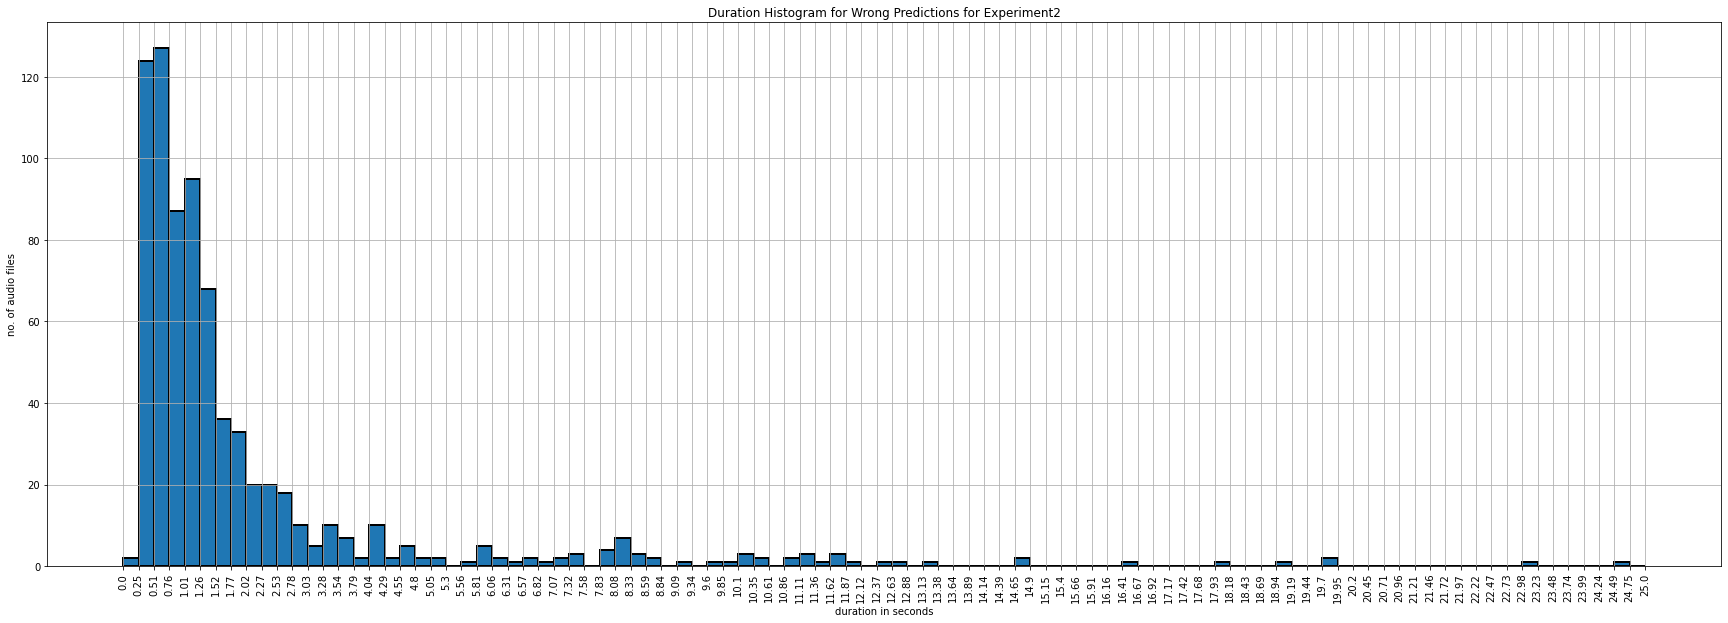

In [76]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

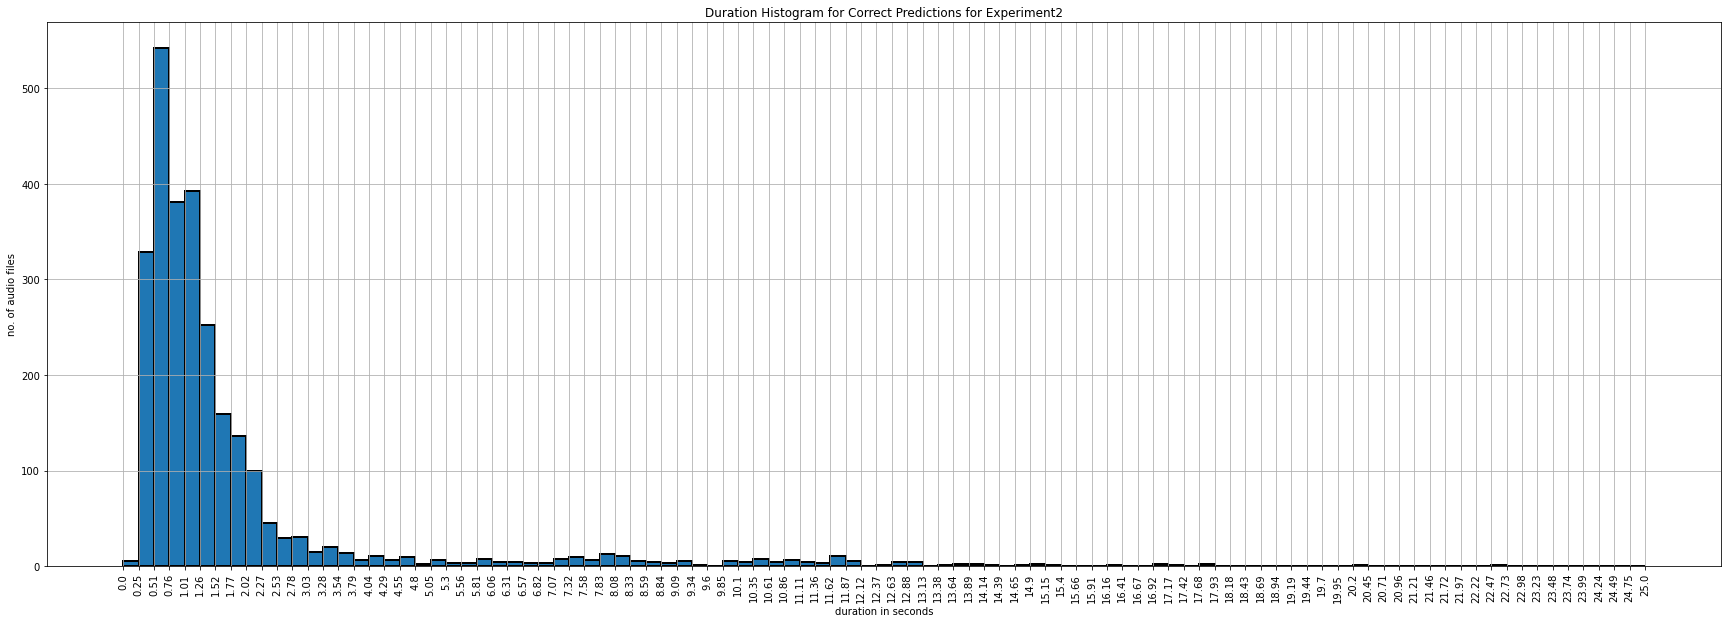

In [77]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment2

In [78]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

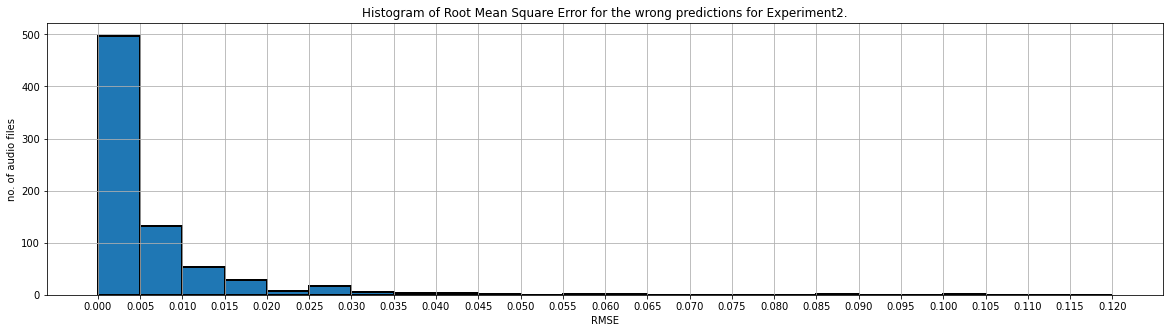

In [79]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

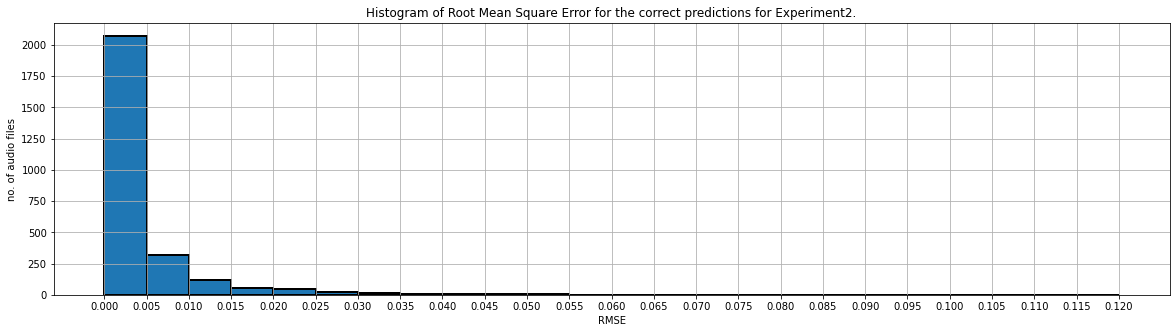

In [80]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

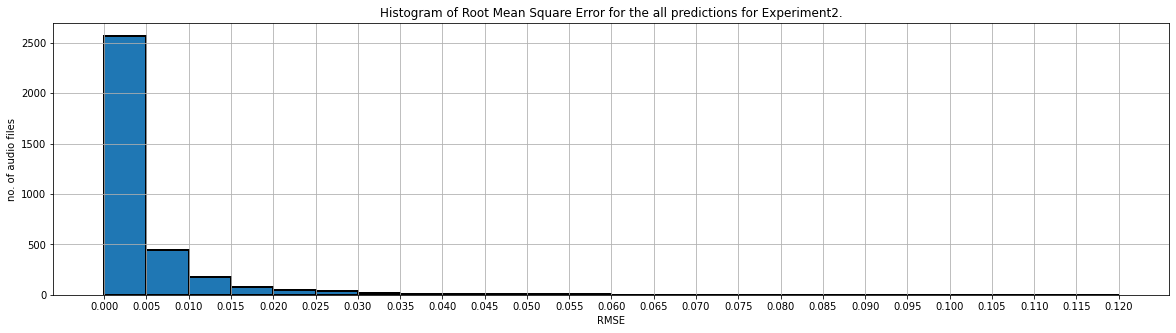

In [81]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [82]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment2

In [83]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83 0.91 0.78 0.59 0.79 0.88 0.8  0.92 0.72 0.72 0.73 0.65 0.74 0.51
 0.77 0.88 0.65 0.86 0.77 0.74]
Precision:  [0.88 0.84 0.72 0.71 0.78 0.87 0.85 0.84 0.6  0.81 0.83 0.72 0.77 0.56
 0.9  0.85 0.59 0.82 0.76 0.78]
F1-Score:  [0.86 0.88 0.75 0.64 0.78 0.87 0.82 0.88 0.65 0.76 0.78 0.68 0.76 0.54
 0.83 0.86 0.62 0.84 0.77 0.76]
Accuracy: 0.78  , 2666
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.84      0.91      0.88       236
           2       0.72      0.78      0.75       180
           3       0.71      0.59      0.64       222
           4       0.78      0.79      0.78       212
           5       0.87      0.88      0.87       178
           6       0.85      0.80      0.82       213
           7       0.84      0.92      0.88       173
           8       0.60      0.72      0.65       220
           9       0.81      0.72      0.76       163
          10     

In [84]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [85]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

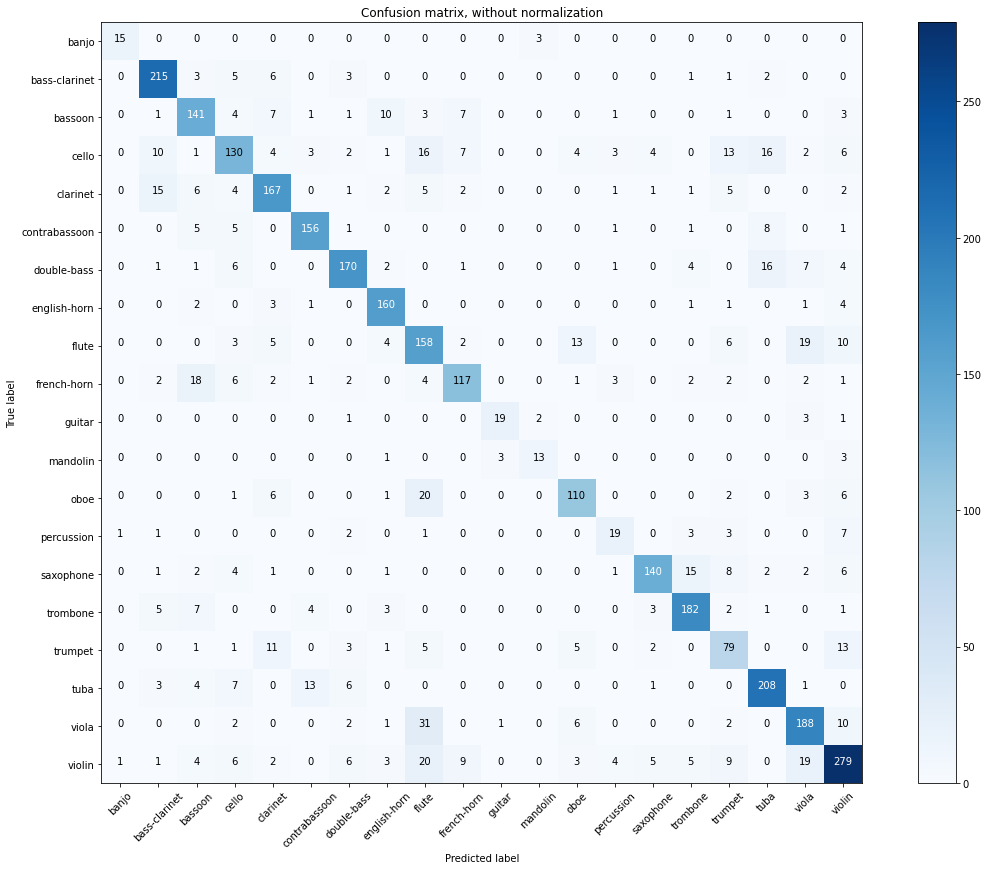

In [86]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

#  load pickle file needed for plotting results for experiment 3

In [87]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment3/histexp3.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [88]:
hist = hist1['hist']
print(hist)

{'valid_loss': [0.45355488052847814], 'valid_loss_decoder': [8.580748466302861e-05], 'valid_loss_total': [0.46213562897414145], 'valid_accuracies': [0.8208902323231864], 'valid_predictions': [[18, 8, 6, 3, 15, 2, 3, 15, 4, 3, 17, 2, 9, 5, 6, 17, 8, 18, 5, 6, 14, 4, 19, 15, 12, 19, 17, 12, 19, 14, 9, 6, 2, 9, 18, 14, 14, 1, 15, 2, 16, 4, 17, 18, 15, 10, 12, 8, 17, 18, 19, 18, 13, 8, 19, 16, 2, 10, 3, 12, 4, 16, 9, 1, 8, 6, 4, 3, 4, 12, 7, 3, 15, 1, 17, 1, 9, 14, 1, 12, 5, 15, 8, 9, 9, 13, 17, 8, 6, 12, 6, 4, 1, 14, 7, 12, 18, 19, 17, 19, 6, 2, 8, 6, 9, 12, 19, 2, 3, 8, 16, 1, 5, 6, 1, 1, 18, 15, 7, 18, 17, 13, 2, 8, 19, 15, 6, 9, 17, 7, 14, 2, 8, 12, 18, 19, 6, 9, 19, 17, 18, 17, 15, 6, 5, 18, 4, 6, 14, 2, 15, 17, 4, 8, 5, 9, 19, 7, 4, 6, 8, 5, 4, 7, 8, 17, 14, 17, 5, 19, 15, 17, 17, 1, 4, 4, 1, 8, 9, 5, 6, 19, 1, 14, 12, 2, 3, 19, 11, 3, 14, 15, 10, 18, 1, 17, 14, 19, 16, 3, 12, 2, 8, 8, 16, 0, 16, 1, 1, 15, 3, 4, 3, 4, 15, 12, 17, 19, 9, 8, 19, 13, 19, 6, 17, 6, 14, 12, 1, 8, 1, 14, 1

In [89]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 609 (out of 3421)
Validation correct 2812 (out of 3421)


In [90]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

print(type(rmse_all_pred))
print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3418, 3419, 3420]),)
<class 'list'>
[array(0., dtype=float32)]


In [91]:
test_list = test_set['duration'].values.tolist()
print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

[1.123265306122449, 0.6008163265306122, 2.1681632653061222, 1.123265306122449, 1.0971428571428572, 1.2277551020408164, 0.5485714285714286, 0.9926530612244898, 0.39183673469387753, 1.0710204081632653, 0.5224489795918368, 0.3395918367346939, 0.9404081632653061, 0.6791836734693878, 1.9591836734693877, 1.0971428571428572, 1.3061224489795917, 1.2016326530612245, 3.5787755102040815, 1.8808163265306121, 0.6008163265306122, 0.5485714285714286, 3.082448979591837, 0.4179591836734694, 0.47020408163265304, 1.8808163265306121, 1.0710204081632653, 1.8808163265306121, 1.8024489795918368, 1.28, 1.8808163265306121, 1.3322448979591837, 1.28, 0.4440816326530612, 0.5224489795918368, 0.809795918367347, 0.2873469387755102, 0.6008163265306122, 1.3061224489795917, 1.3061224489795917, 1.123265306122449, 1.5151020408163265, 1.8285714285714285, 1.5412244897959184, 0.7053061224489796, 5.877551020408164, 0.9926530612244898, 0.9404081632653061, 0.9926530612244898, 0.6530612244897959, 0.7575510204081632, 1.149387755

In [92]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [54]:
print(len(correct_pred_value))

2812


In [93]:
ranges_dur = np.linspace(0,25, num=100)
print(ranges_dur)
print(np.round(ranges_dur,2))


[ 0.    0.25  0.51  0.76  1.01  1.26  1.52  1.77  2.02  2.27  2.53  2.78
  3.03  3.28  3.54  3.79  4.04  4.29  4.55  4.8   5.05  5.3   5.56  5.81
  6.06  6.31  6.57  6.82  7.07  7.32  7.58  7.83  8.08  8.33  8.59  8.84
  9.09  9.34  9.6   9.85 10.1  10.35 10.61 10.86 11.11 11.36 11.62 11.87
 12.12 12.37 12.63 12.88 13.13 13.38 13.64 13.89 14.14 14.39 14.65 14.9
 15.15 15.4  15.66 15.91 16.16 16.41 16.67 16.92 17.17 17.42 17.68 17.93
 18.18 18.43 18.69 18.94 19.19 19.44 19.7  19.95 20.2  20.45 20.71 20.96
 21.21 21.46 21.72 21.97 22.22 22.47 22.73 22.98 23.23 23.48 23.74 23.99
 24.24 24.49 24.75 25.  ]
[ 0.    0.25  0.51  0.76  1.01  1.26  1.52  1.77  2.02  2.27  2.53  2.78
  3.03  3.28  3.54  3.79  4.04  4.29  4.55  4.8   5.05  5.3   5.56  5.81
  6.06  6.31  6.57  6.82  7.07  7.32  7.58  7.83  8.08  8.33  8.59  8.84
  9.09  9.34  9.6   9.85 10.1  10.35 10.61 10.86 11.11 11.36 11.62 11.87
 12.12 12.37 12.63 12.88 13.13 13.38 13.64 13.89 14.14 14.39 14.65 14.9
 15.15 15.4  15.66 15.91 16

Duration histograms for wrong and correct predictions for experiment3

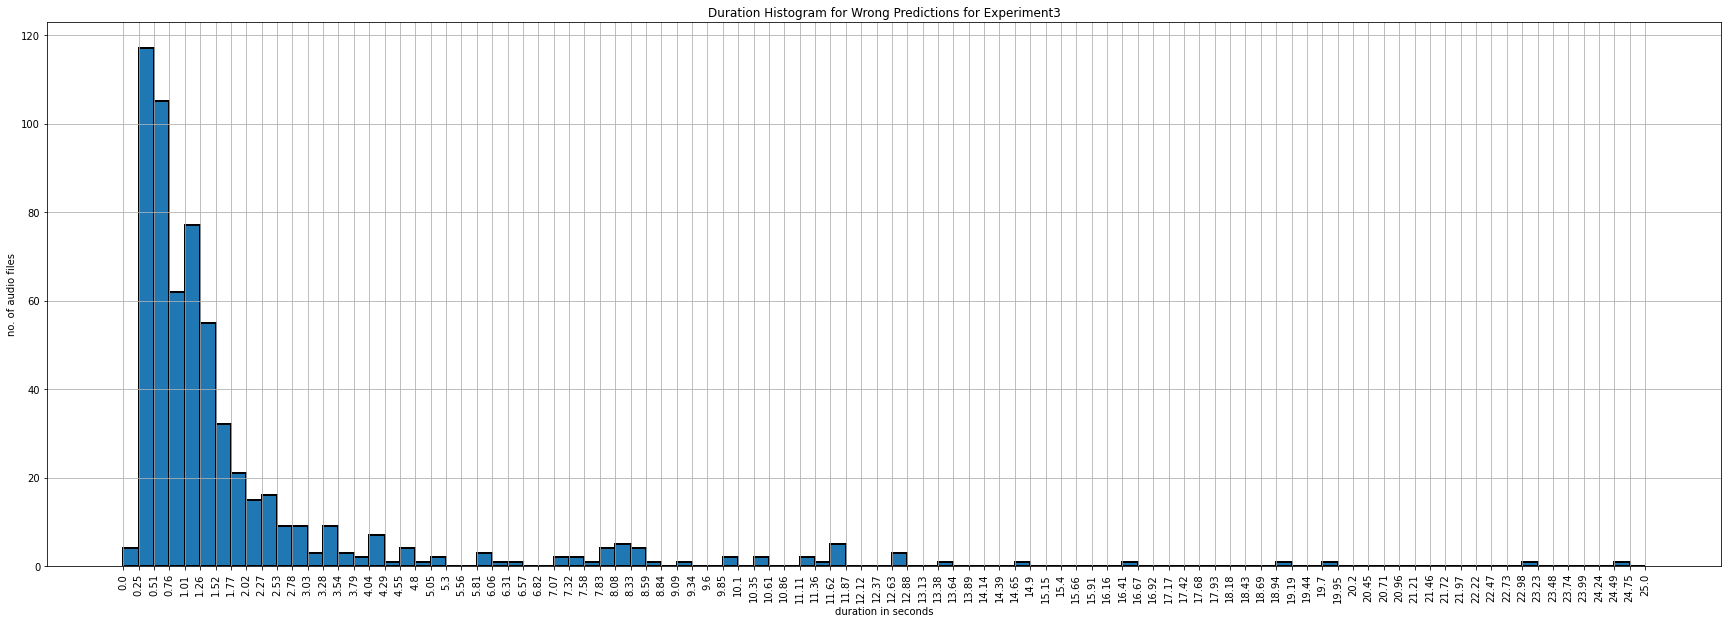

In [94]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

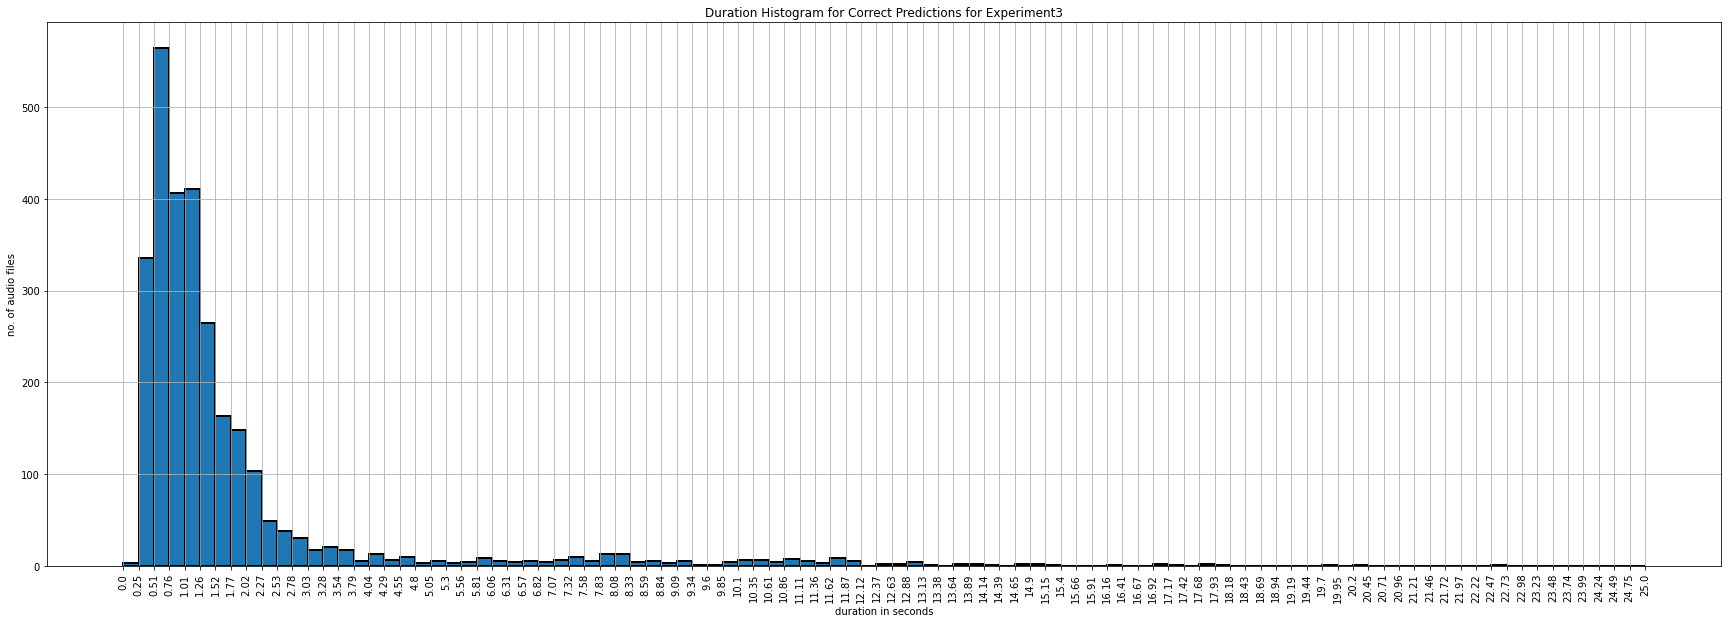

In [95]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment3

In [96]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

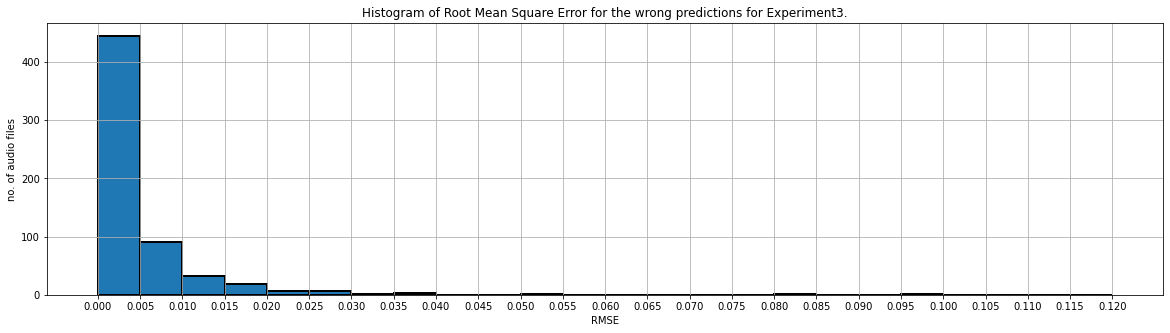

In [97]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

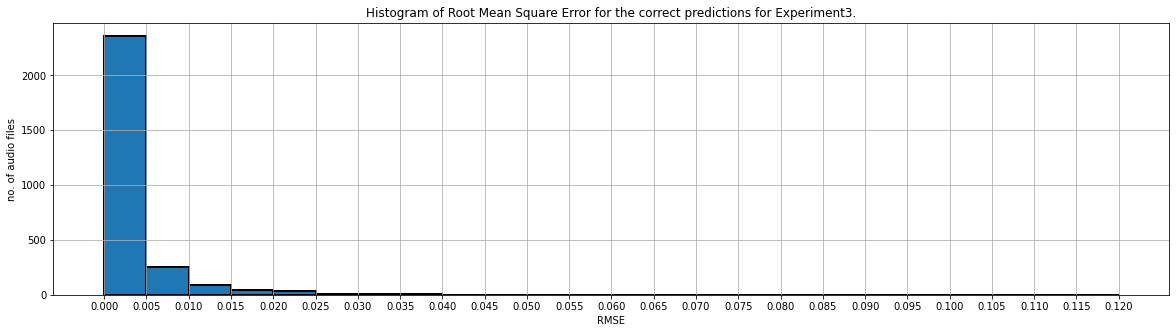

In [98]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

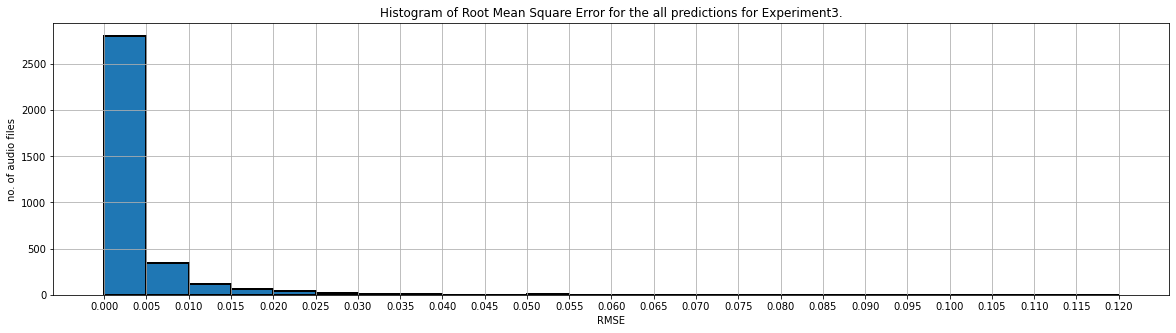

In [99]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [100]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment3

In [101]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.89 0.91 0.85 0.71 0.82 0.9  0.82 0.96 0.73 0.83 0.81 0.55 0.81 0.51
 0.81 0.91 0.64 0.88 0.82 0.8 ]
Precision:  [0.84 0.93 0.85 0.75 0.82 0.87 0.85 0.87 0.64 0.85 0.75 0.79 0.8  0.68
 0.94 0.9  0.68 0.88 0.77 0.81]
F1-Score:  [0.86 0.92 0.85 0.73 0.82 0.88 0.84 0.91 0.68 0.84 0.78 0.65 0.8  0.58
 0.87 0.9  0.66 0.88 0.79 0.8 ]
Accuracy: 0.82  , 2812
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.93      0.91      0.92       236
           2       0.85      0.85      0.85       180
           3       0.75      0.71      0.73       222
           4       0.82      0.82      0.82       212
           5       0.87      0.90      0.88       178
           6       0.85      0.82      0.84       213
           7       0.87      0.96      0.91       173
           8       0.64      0.73      0.68       220
           9       0.85      0.83      0.84       163
          10     

In [102]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [103]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

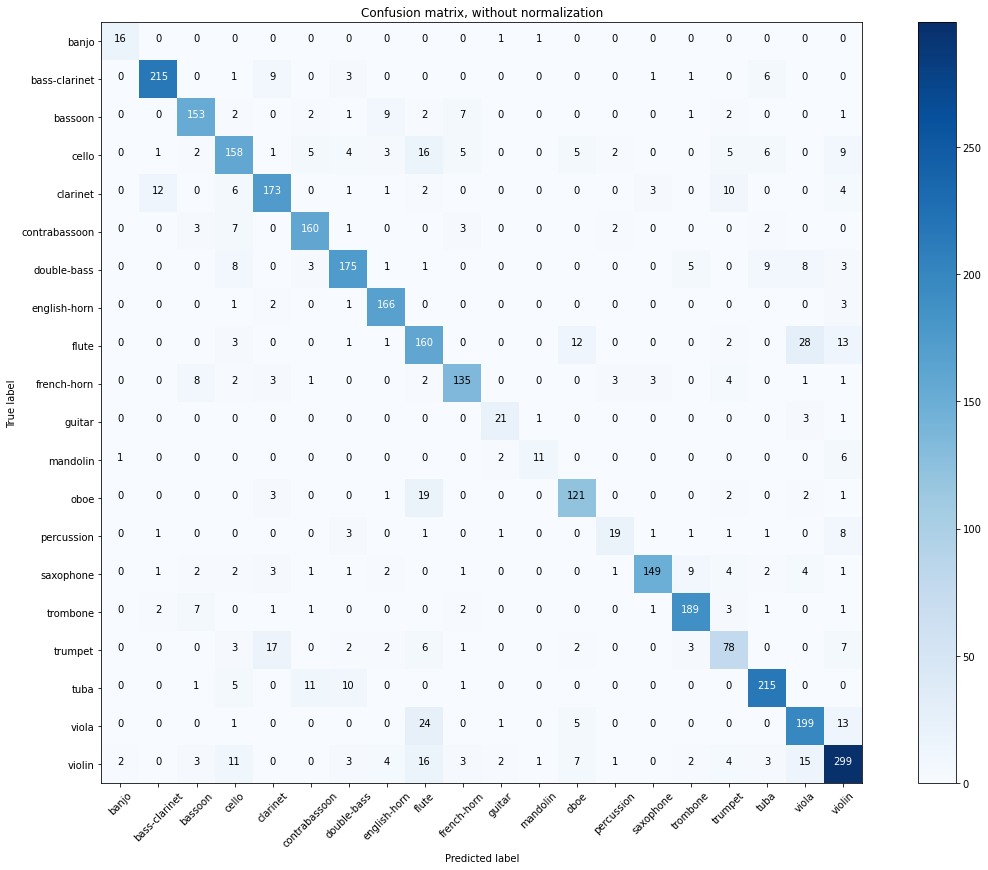

In [104]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')